<a href="https://colab.research.google.com/github/halldm2000/NOAA-AI-2020-TUTORIAL/blob/master/curve_fit_wind_vs_pressure_v0_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Install Python Package for reading NetCDF files**

In [1]:
!pip install netCDF4

     |████████████████████████████████| 4.3MB 2.7MB/s 
     |████████████████████████████████| 296kB 38.3MB/s 


**Download Data from NOAA**

In [2]:
import os
source = "https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/netcdf/IBTrACS.ALL.v04r00.nc"
dest    = "data/ibtracs/"
!wget -c -e robots=off -P {dest} {source}

--2020-10-08 21:49:52--  https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/netcdf/IBTrACS.ALL.v04r00.nc
Resolving www.ncei.noaa.gov (www.ncei.noaa.gov)... 205.167.25.172, 205.167.25.177, 205.167.25.178, ...
Connecting to www.ncei.noaa.gov (www.ncei.noaa.gov)|205.167.25.172|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25833929 (25M) [application/x-netcdf]
Saving to: ‘data/ibtracs/IBTrACS.ALL.v04r00.nc’

IBTrACS.ALL.v04r00. 100%[===================>]  24.64M  7.56MB/s    in 3.3s    

2020-10-08 21:49:56 (7.56 MB/s) - ‘data/ibtracs/IBTrACS.ALL.v04r00.nc’ saved [25833929/25833929]



**Load Cyclone Data From File**

In [3]:
import xarray as xr, numpy as np

# read data from file
ds   = xr.open_dataset("/content/data/ibtracs/IBTrACS.ALL.v04r00.nc")
wind = ds['usa_wind'].data
pres = ds['usa_pres'].data

# find indices where both variables are valid
wind_valid = ~np.isnan(wind)
pres_valid = ~np.isnan(pres)
valid      = np.logical_and(pres_valid,wind_valid)

# keep only valid data
wind = wind[valid]
pres = pres[valid]

**Plot Pressure vs Windspeed**

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.scatter(pres,wind,s=50,alpha=0.1)
plt.title("Pressure vs Windspeed obserations")
plt.xlabel(ds['usa_pres'].long_name)
plt.ylabel(ds['usa_wind'].long_name);
plt.ylim(bottom=0);

NameError: ignored

<Figure size 720x720 with 0 Axes>

**Define routine for plotting curve-fit and training loss**

In [9]:
def plot_fit_and_loss(input,pred,train_loss):

  plt.figure(figsize=(20,10))
  plt.subplot(1, 2, 1)

  plt.scatter(pres,wind,s=50,alpha=0.1)
  plt.xlabel(ds['usa_pres'].long_name)
  plt.ylabel(ds['usa_wind'].long_name);
  plt.ylim(bottom=0)

  x = xscaler.inverse_transform(input)
  y = yscaler.inverse_transform(pred)
  plt.plot(x,y,color='orange', linewidth=3)

  plt.subplot(1, 2, 2)
  plt.semilogy(train_loss)
  plt.xlabel("batch number")
  plt.ylabel("training loss")
  plt.show()


**Train a neural net to fit the observations**

epoch=0 training loss=0.7543829679489136 dt=1.56


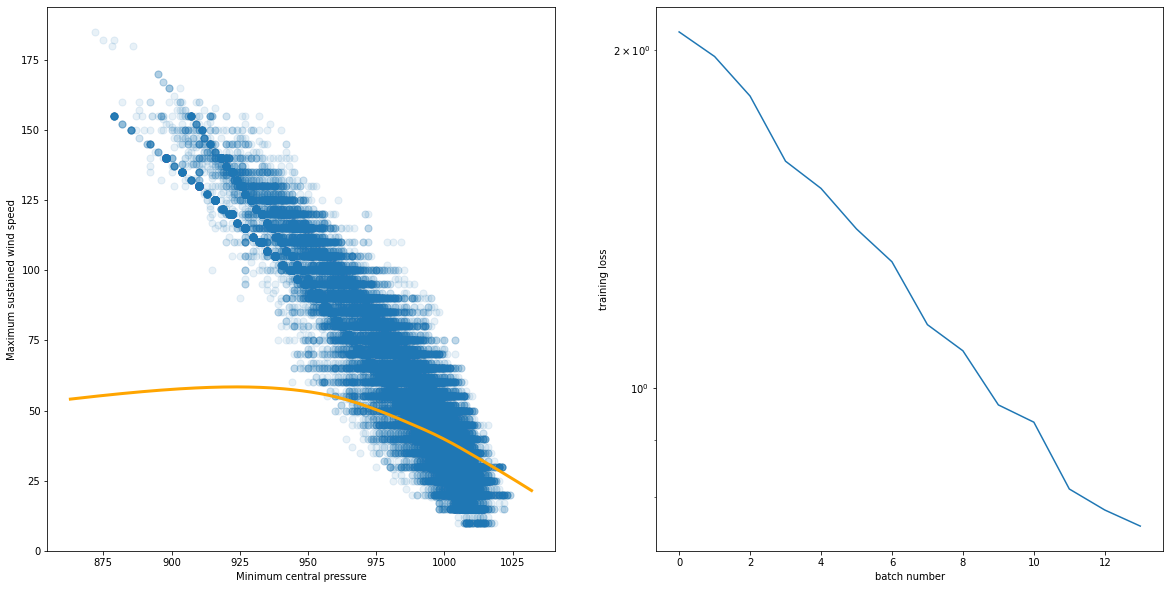

epoch=1 training loss=0.28955382108688354 dt=1.57


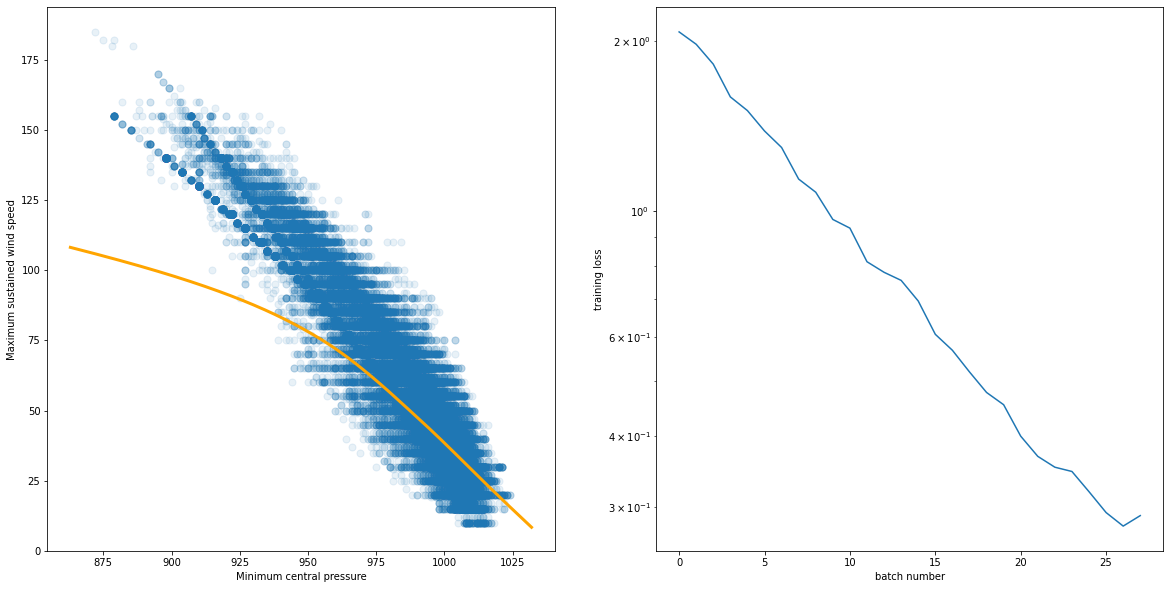

epoch=2 training loss=0.14772628247737885 dt=1.67


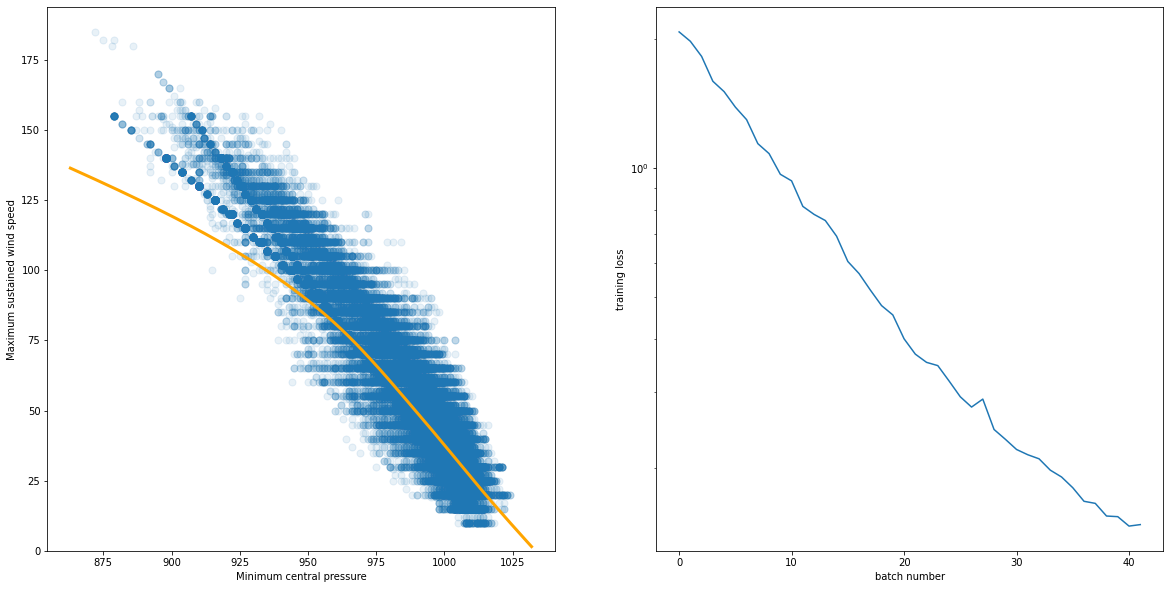

epoch=3 training loss=0.11484154313802719 dt=1.74


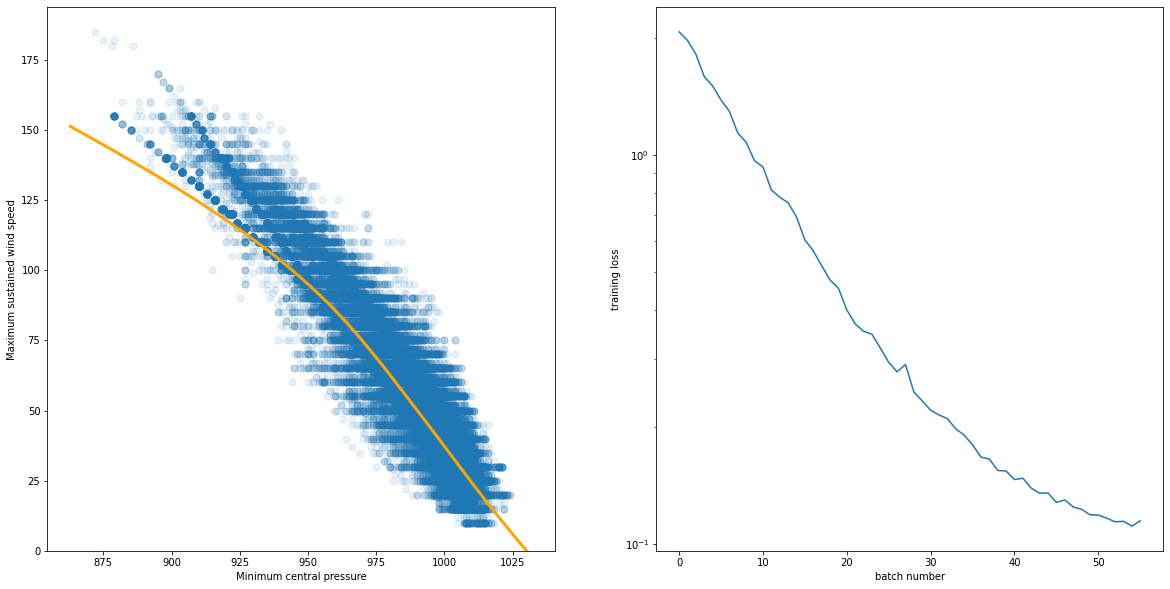

epoch=4 training loss=0.10276313871145248 dt=1.70


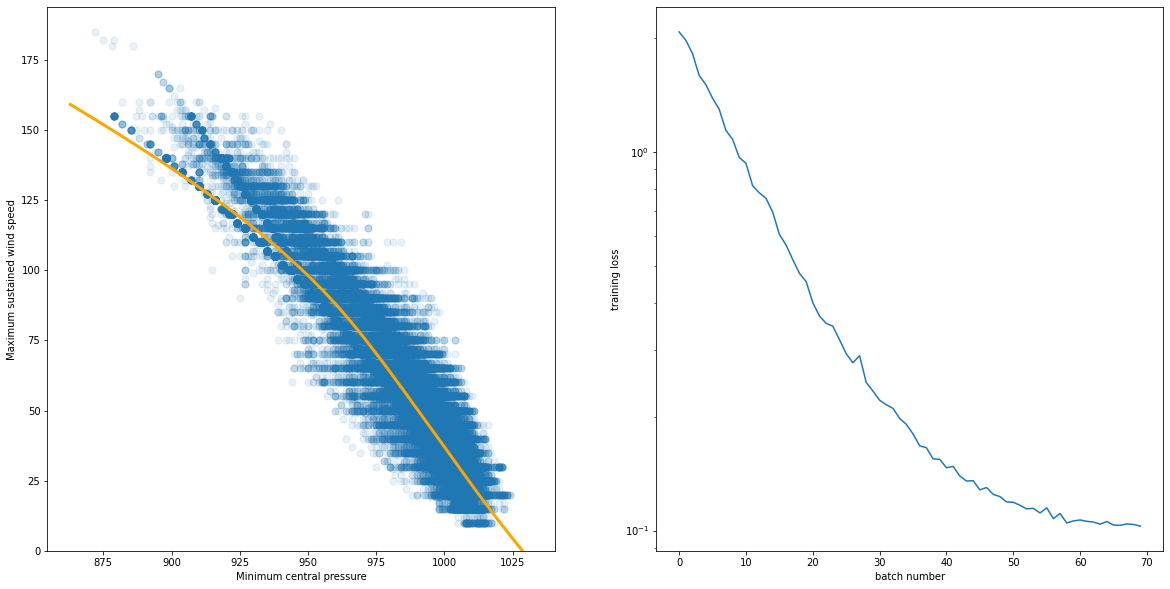

epoch=5 training loss=0.10502326488494873 dt=1.66


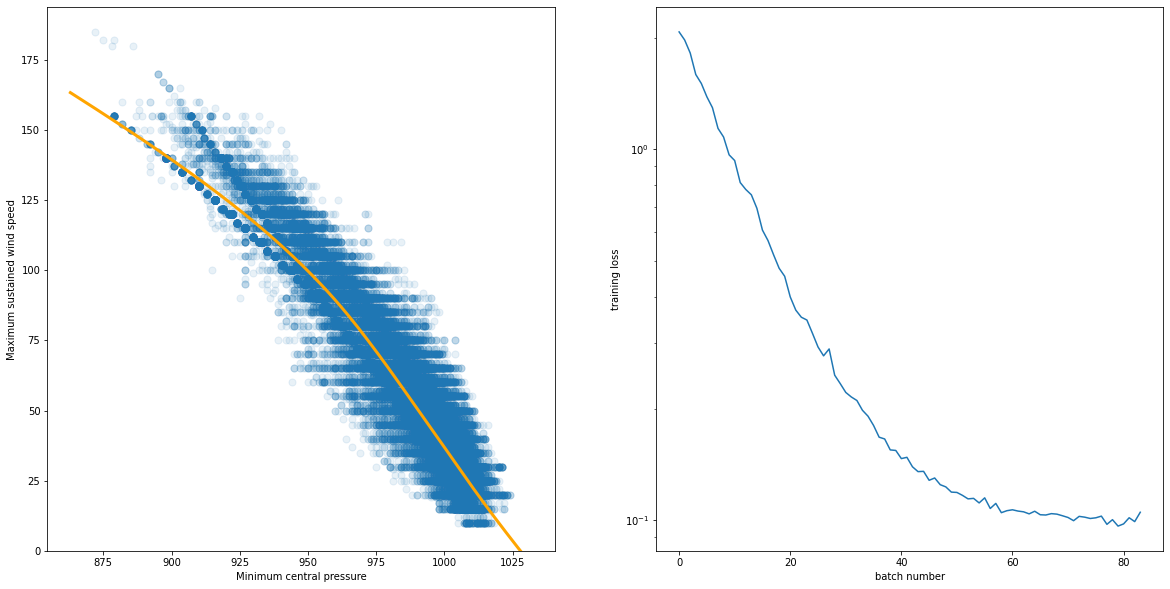

epoch=6 training loss=0.09868228435516357 dt=1.73


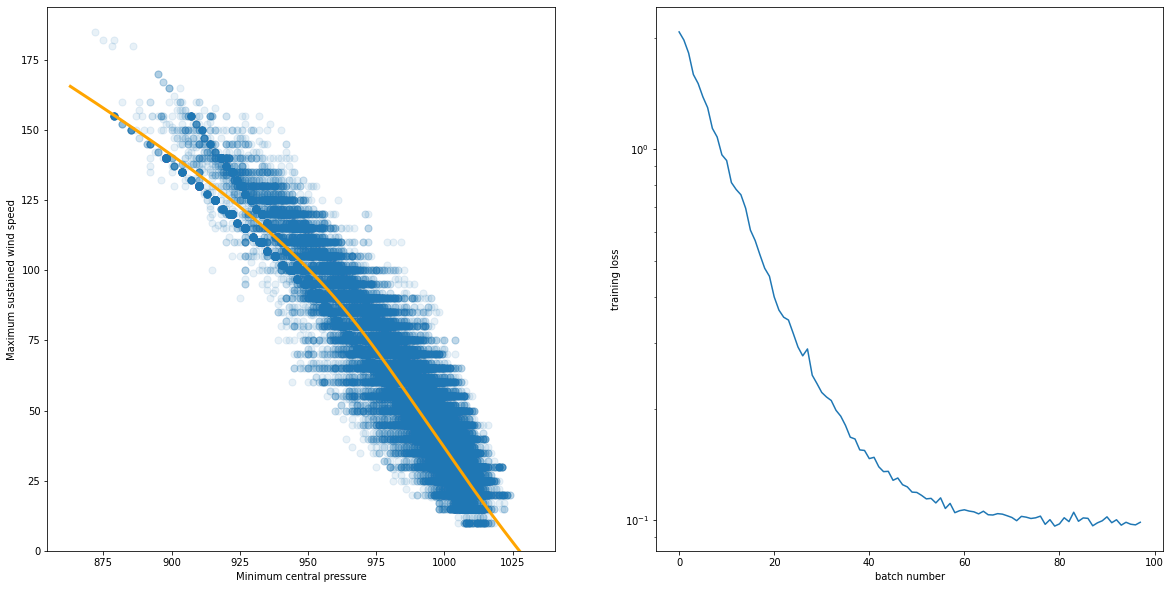

epoch=7 training loss=0.10041915625333786 dt=1.68


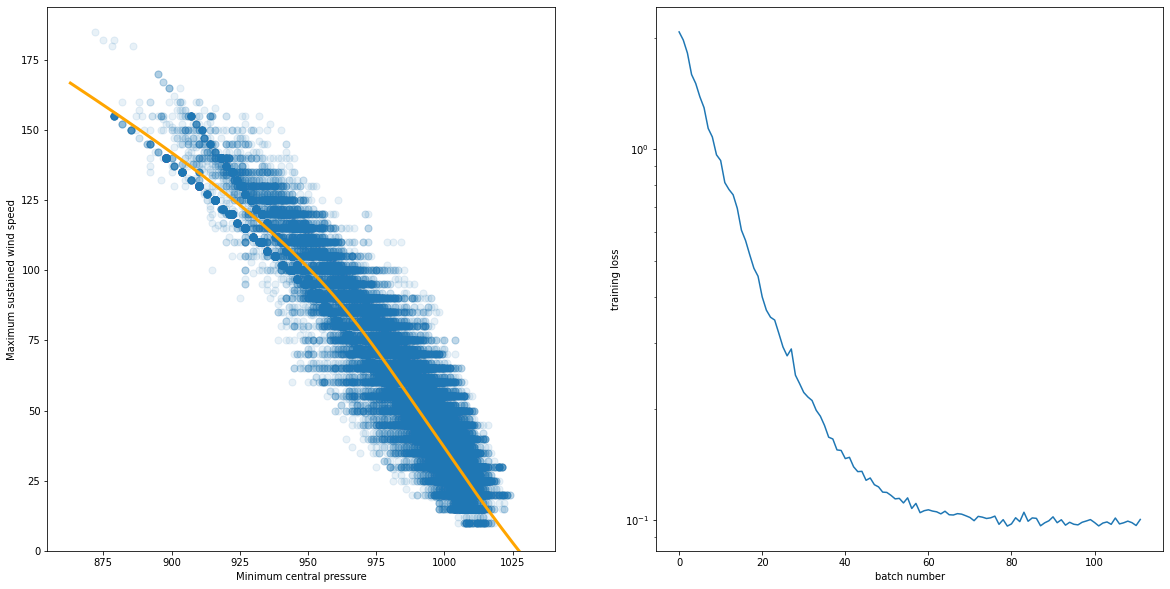

epoch=8 training loss=0.09903650730848312 dt=1.66


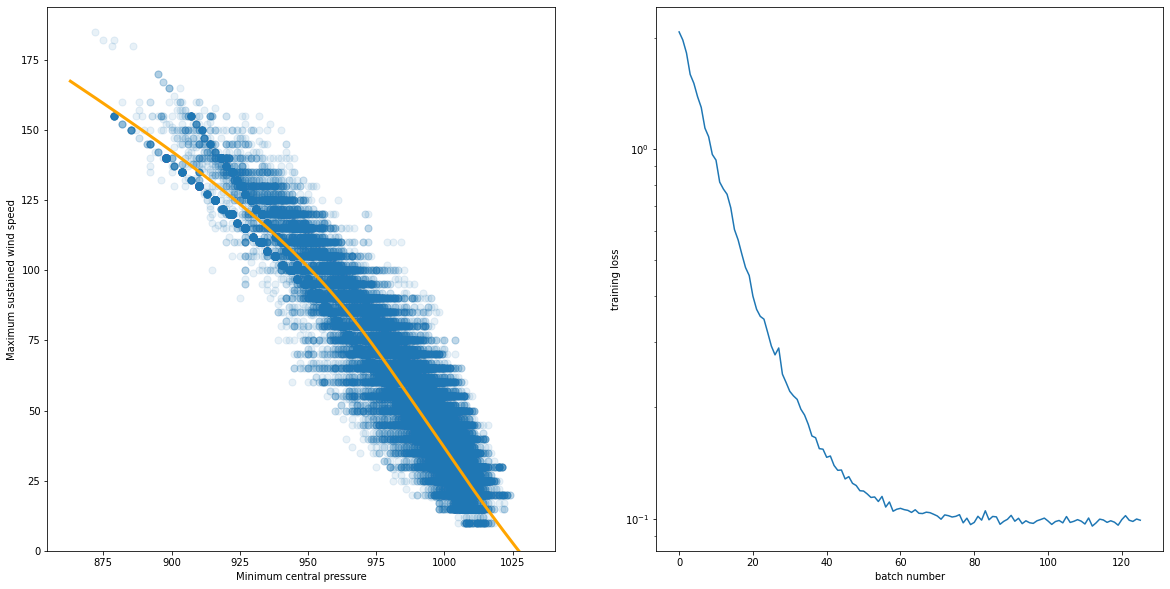

epoch=9 training loss=0.0992807000875473 dt=1.66


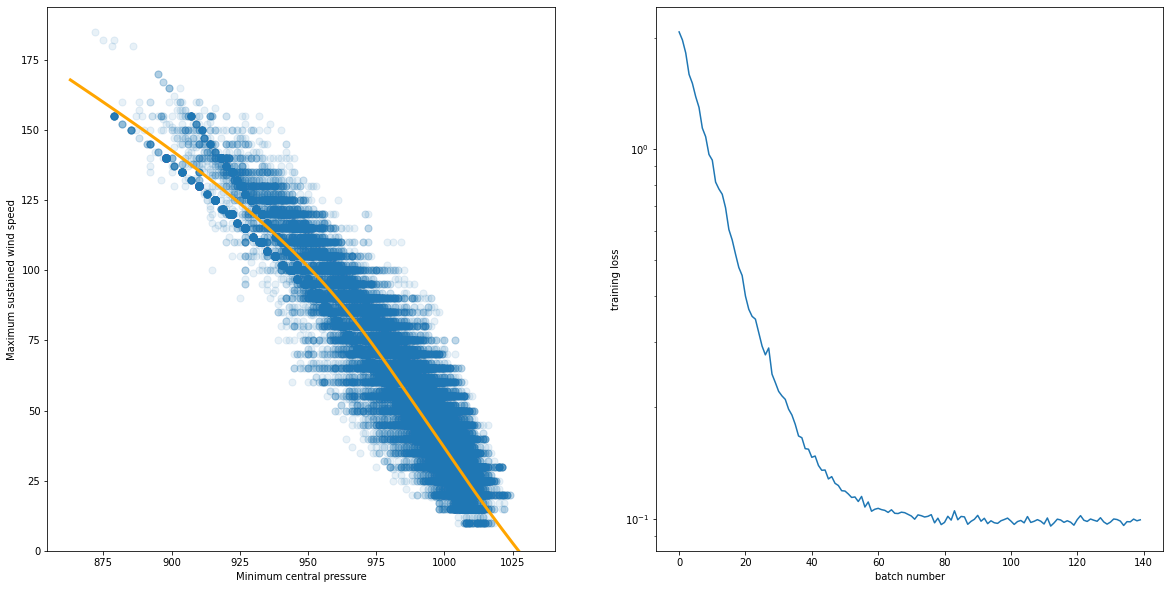

epoch=10 training loss=0.09527131170034409 dt=1.67


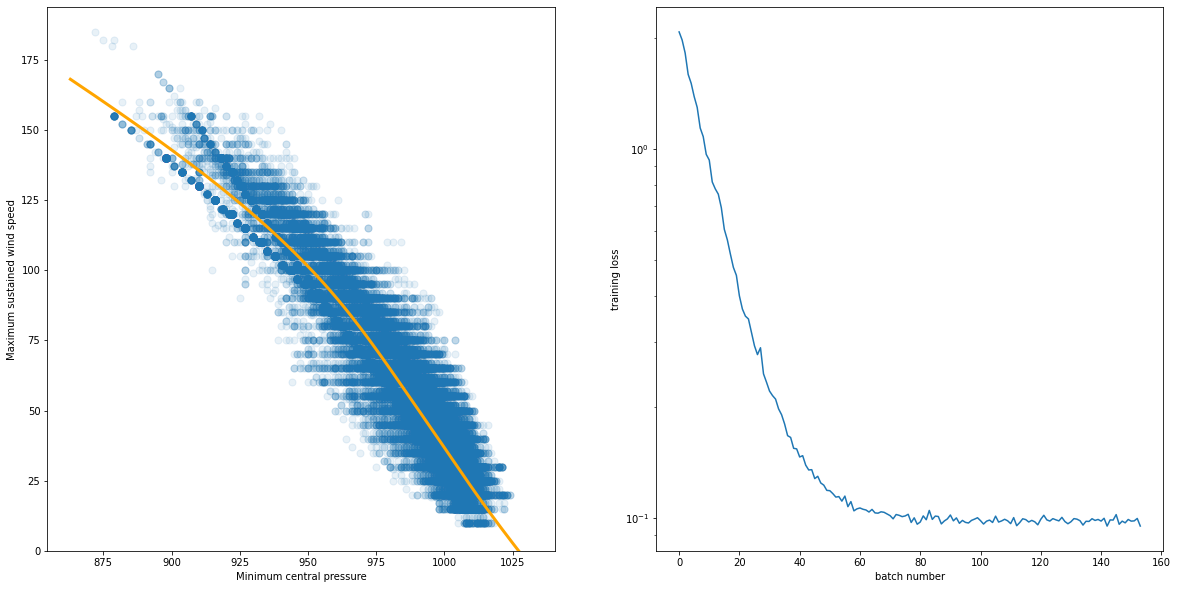

epoch=11 training loss=0.09847919642925262 dt=1.67


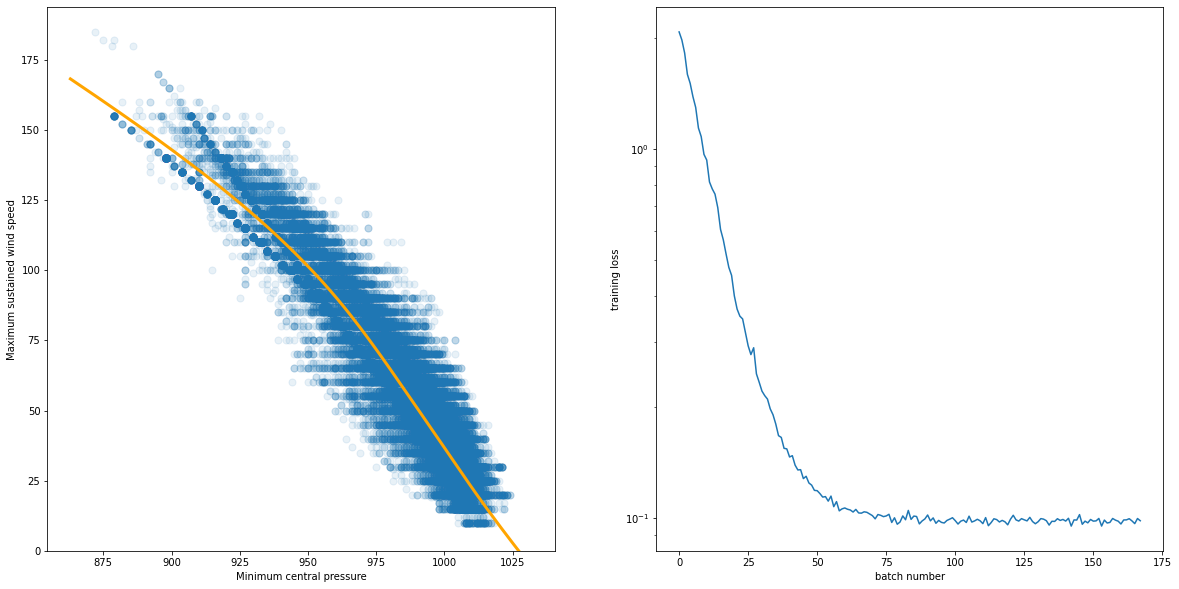

epoch=12 training loss=0.09965317696332932 dt=1.71


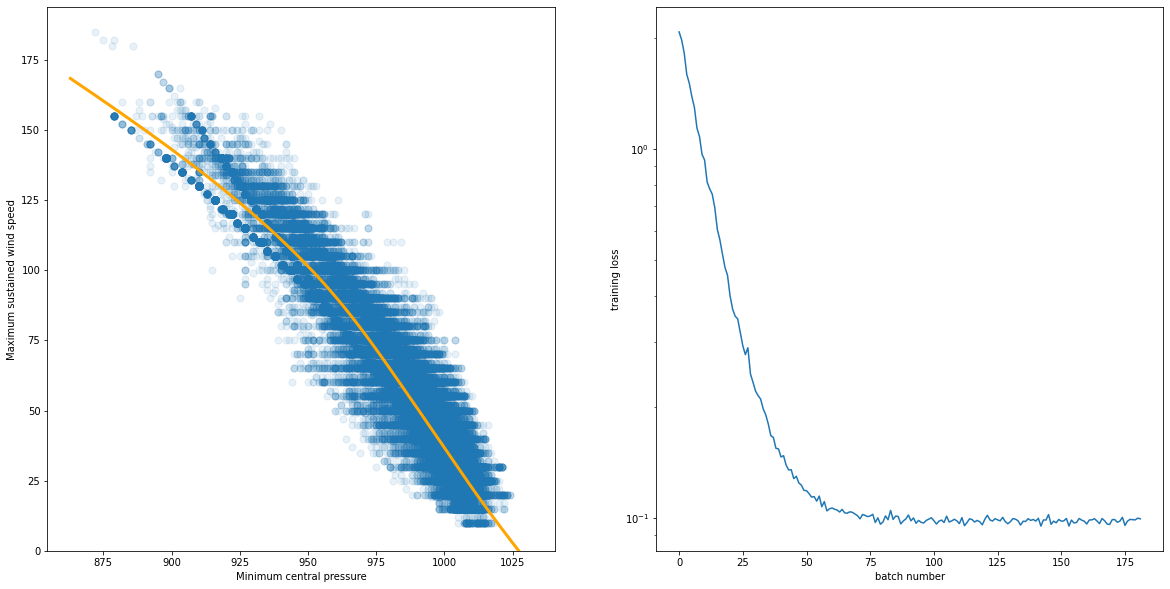

epoch=13 training loss=0.09478852897882462 dt=1.70


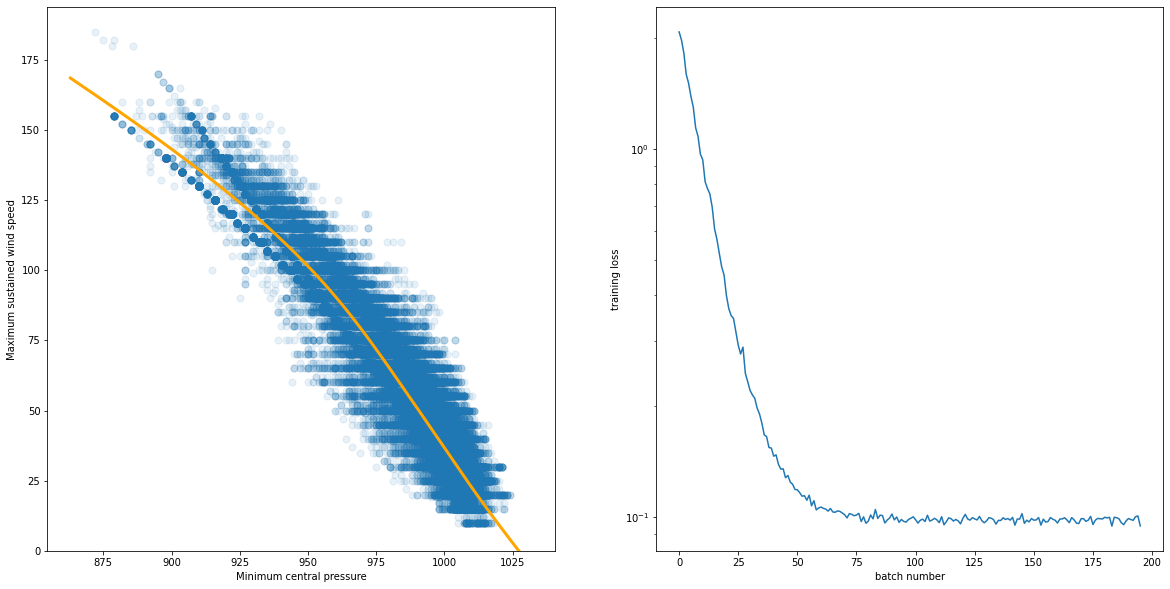

epoch=14 training loss=0.09624431282281876 dt=1.70


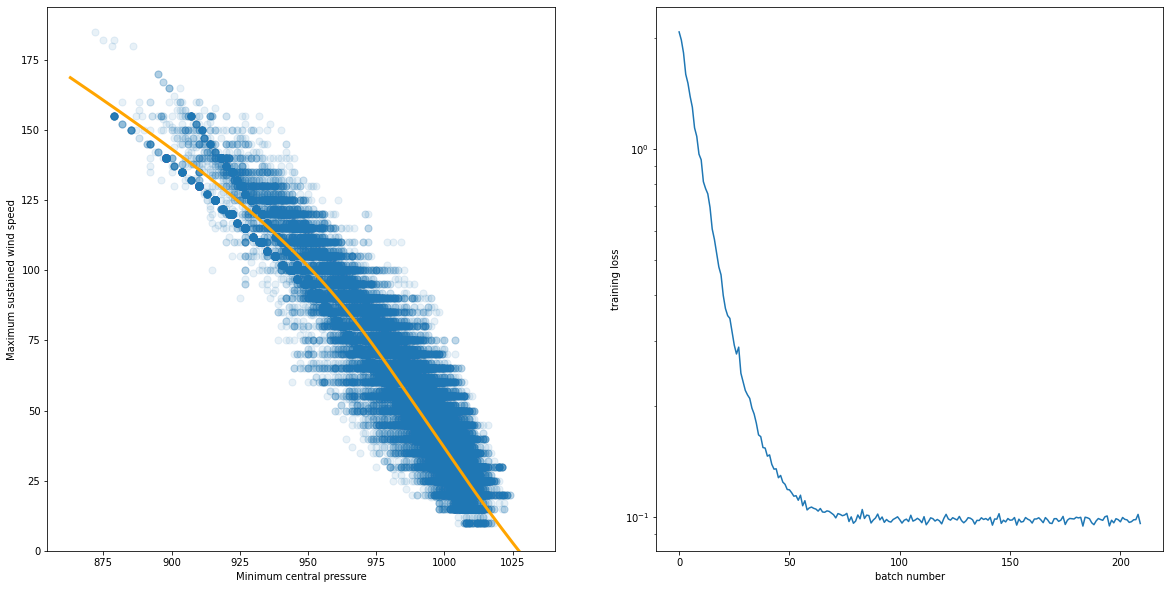

epoch=15 training loss=0.09873548150062561 dt=1.67


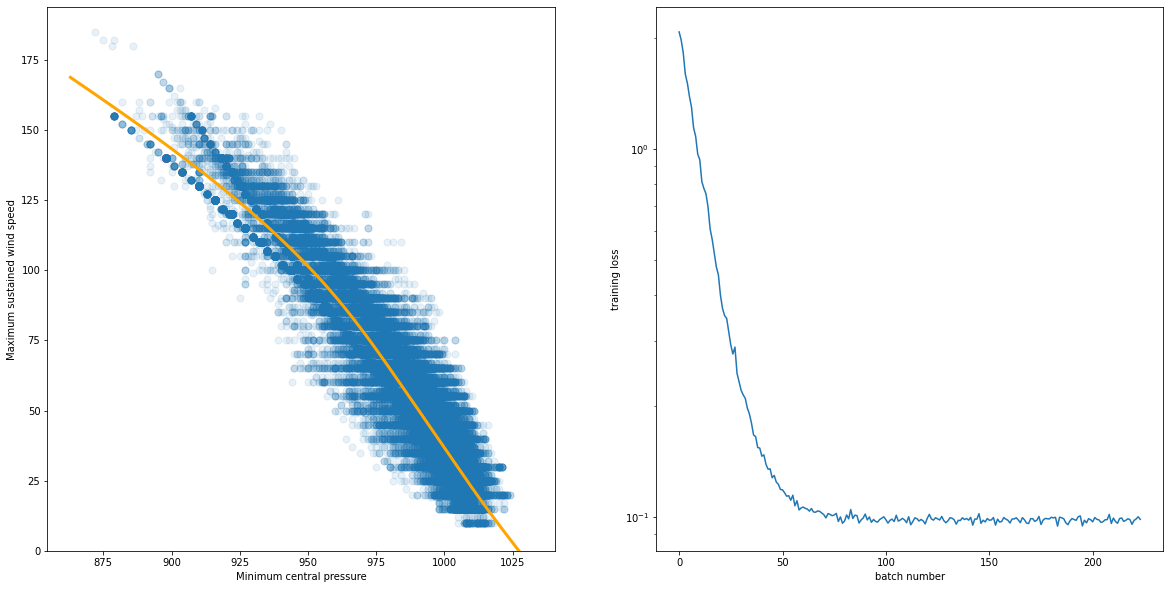

epoch=16 training loss=0.09570068120956421 dt=1.77


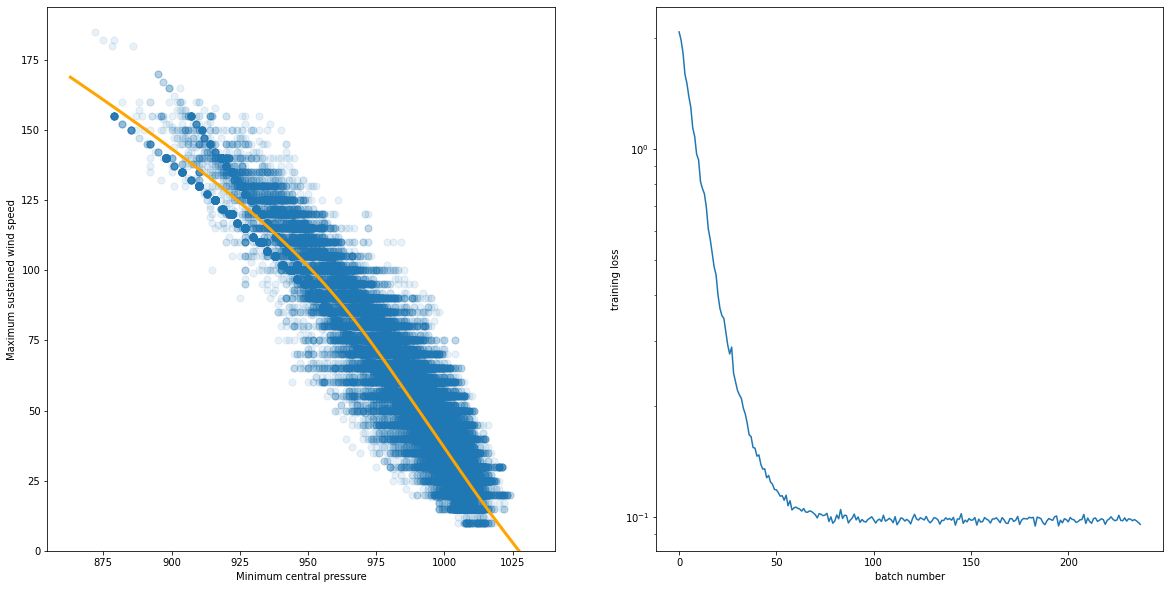

epoch=17 training loss=0.0984143391251564 dt=1.67


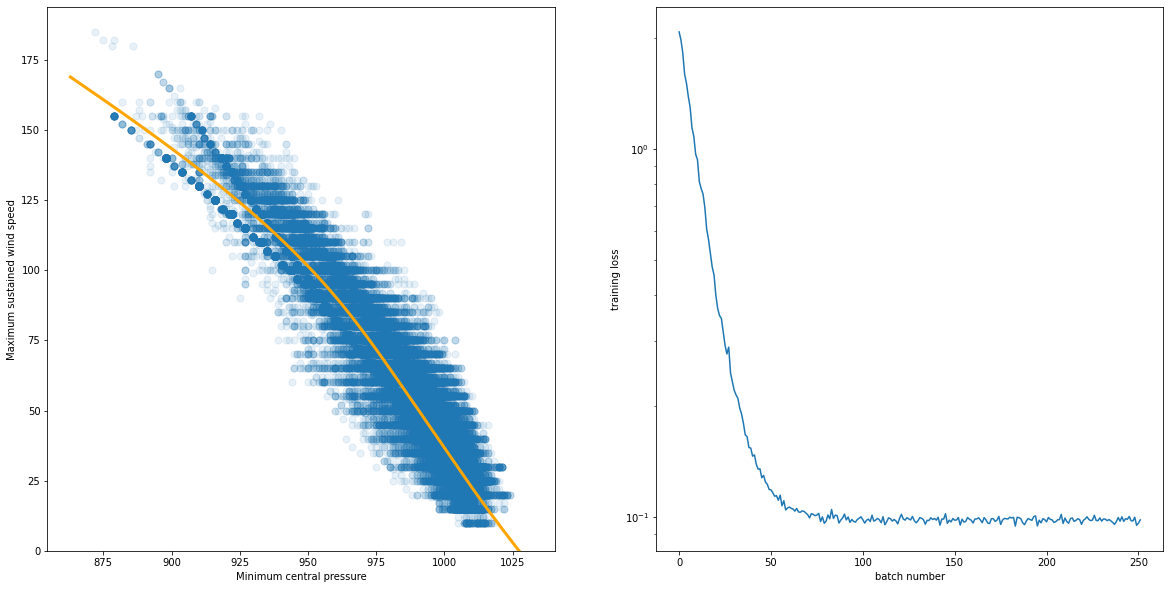

epoch=18 training loss=0.10018694400787354 dt=1.67


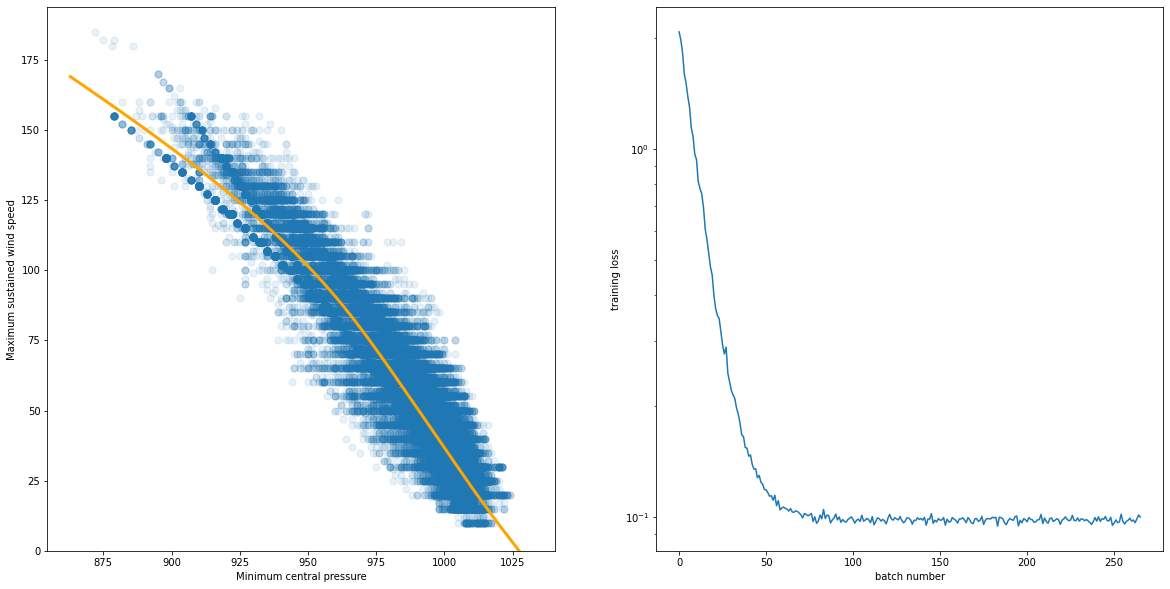

epoch=19 training loss=0.10137203335762024 dt=1.68


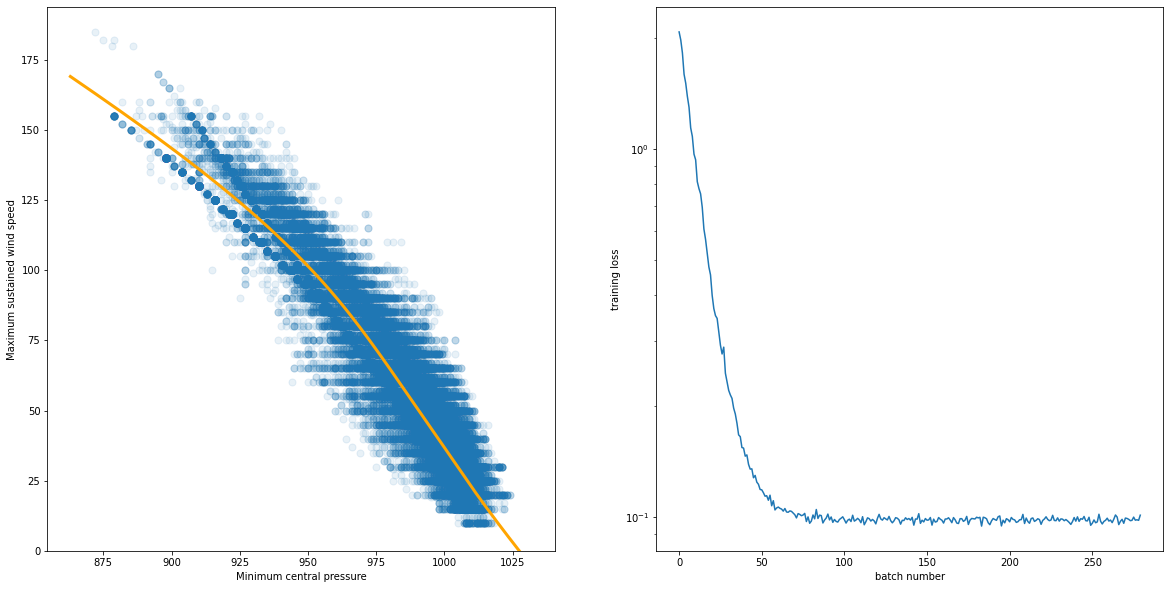

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

import torch, torch.nn as nn, torch.optim as optim, torch.utils.data as data
from sklearn.preprocessing import StandardScaler

import time

# DATA

# reshape data to (nsamples, nvariables)
x = pres.reshape(-1,1)
y = wind.reshape(-1,1)

# normalize data
xscaler = StandardScaler()
yscaler = StandardScaler()

X = xscaler.fit_transform(x)
Y = yscaler.fit_transform(y)

# create a pytorch dataset and data loader from the numpy arrays
X = torch.tensor(X)
Y = torch.tensor(Y)
train_dataset = data.TensorDataset(X, Y)
train_loader  = data.DataLoader(train_dataset, batch_size=10000, shuffle=True, num_workers=0)

# MODEL

N = 100
model = nn.Sequential(
    nn.Linear(1  ,N), nn.ELU(),
    nn.Linear(N,1  )
)

optimizer = optim.SGD(model.parameters(), lr=1e-3)
loss_fcn  = nn.MSELoss() # mean-squared error loss

# TRAIN

losses = []
for epoch in range(20):

  t =time.time()
  model.train()

  for i, (input,target) in enumerate(train_loader):

    # get model prediction
    prediction = model(input)
    
    # adjust model parameters
    optimizer.zero_grad()
    train_loss = loss_fcn(prediction,target)
    train_loss.backward()
    optimizer.step()
    losses.extend([train_loss.item()])

  # plot curve fit and training loss

  model.eval()

  with torch.no_grad():

    # print loss and time to train one epoch
    dt = time.time()- t 
    print(f"epoch={epoch} training loss={train_loss.item()} dt={dt:.2f}")#,end="\r")
    
    # plot curve fit, at regularly spaced points
    input = torch.linspace(-6,2,200).view(-1,1)
    pred = model(input)
    plot_fit_and_loss(input.numpy(), pred.numpy(),losses)
